In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0890.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0282.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0785.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0023.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0823.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0586.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0697.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0760.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0290.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0135.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0912.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0212.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_baldy/aesh_baldy_0708.jpg
/kaggle/input/my-food-100-dataset/food100/aesh_bald

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import zipfile
import json
import time

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


In [11]:
# === CONFIGURATION (Our "Control Panel") ===

# --- 1. Data ---
# Kaggle unzipped our data, so we point DIRECTLY to the unzipped folder
# 🛑 غيّر المسار ده للمسار الصح اللي طلعلك
DATA_DIR = "/kaggle/input/my-food-100-dataset/food100" 

# --- 2. Model ---
MODEL_CHOICE = tf.keras.applications.EfficientNetB0
IMG_SIZE = 224
NUM_CLASSES = 100
SEED = 42

# --- 3. Training ---
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EPOCHS_WARMUP = 10
EPOCHS_FINE_TUNE = 30
LR_WARMUP = 0.001
LR_FINE_TUNE = 0.00001

In [12]:
# --- Cell 5: Step 2: Load & Prepare Datasets ---

print("\n--- Step 2: Loading & Splitting Data ---")

# We load directly from the DATA_DIR in /kaggle/input
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,  # This points to the unzipped folder
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,  # This points to the unzipped folder
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# --- This is the important part you missed ---
# Save the class names (extremely useful for your final app)
class_names = train_ds.class_names
print(f"\nFound {len(class_names)} classes.")

# Save class names to a JSON file in the output directory
class_names_path = "/kaggle/working/class_names.json"
with open(class_names_path, 'w') as f:
    json.dump(class_names, f)

print(f"Class names saved to {class_names_path}")


--- Step 2: Loading & Splitting Data ---
Found 98340 files belonging to 100 classes.
Using 78672 files for training.
Found 98340 files belonging to 100 classes.
Using 19668 files for validation.

Found 100 classes.
Class names saved to /kaggle/working/class_names.json


In [13]:
print("\n--- Step 3: Defining 'Online' Augmentation Layer ---")

# We build augmentation as a Keras layer.
# This means it runs on the GPU (fast) and is *part* of the saved model.
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    layers.RandomZoom(0.2, seed=SEED),
    layers.RandomContrast(0.2, seed=SEED) # Added for more robustness
], name="data_augmentation")

# Note: EfficientNet *expects* pixel values in the [0, 255] range.
# We do NOT need a Rescaling(1./255) layer or the preprocess_input function.


--- Step 3: Defining 'Online' Augmentation Layer ---


In [14]:
# --- Cell 7: Step 4: Configure Dataset for Performance ---

print("\n--- Step 4: Configuring Dataset for Performance ---")

# We REMOVED .cache() to prevent Out-of-Memory errors.
# We KEEP .prefetch() because it's crucial for performance.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # <--- شيلنا .cache()
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE) # <--- شيلنا .cache()

print("Dataset performance pipeline configured (without cache).")


--- Step 4: Configuring Dataset for Performance ---
Dataset performance pipeline configured (without cache).


In [15]:
print("\n--- Step 5: Building Model (Phase 1 - Warmup) ---")

# 1. Load the pre-trained base model
base_model = MODEL_CHOICE(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# 2. Freeze the base (this is the key to "warmup")
base_model.trainable = False

# 3. Build our full model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_layer")
# Apply augmentation "online"
x = data_augmentation(inputs)
# Pass to the frozen base
x = base_model(x, training=False) 
# Build our new "head"
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.3, name="dropout_layer")(x) # Regularization
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="output_layer")(x)
model = keras.Model(inputs, outputs)

# 4. Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_WARMUP),
    loss="sparse_categorical_crossentropy", # Use sparse (integer labels)
    metrics=["accuracy"]
)

print("Model built and compiled for warmup.")
model.summary()


--- Step 5: Building Model (Phase 1 - Warmup) ---
Model built and compiled for warmup.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 100)            │       128,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,177,671 (15.94 MB)

 Trainable params: 128,100 (500.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
print("\n--- Step 6: Defining Callbacks ---")

# Callbacks are our "safety net" for long training jobs.

# 1. ModelCheckpoint: Saves the *best* model file.
checkpoint_path = "/kaggle/working/best_model_food100.keras"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True, # This is the key!
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

# 2. EarlyStopping: Stops training if it doesn't improve.
# This saves your GPU quota!
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5, # Wait 5 epochs with no improvement
    restore_best_weights=True, # Automatically load the best weights back
    verbose=1
)

# 3. ReduceLROnPlateau: Lowers the learning rate if we get stuck.
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2, # Reduce LR by 80% (new_lr = lr * 0.2)
    patience=2,
    verbose=1
)


--- Step 6: Defining Callbacks ---


In [17]:
print("\n--- Step 7: Starting Training (Phase 1: Warmup) ---")

# We train only the new head
history_warmup = model.fit(
    train_ds,
    epochs=EPOCHS_WARMUP,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

print("Warmup complete.")


--- Step 7: Starting Training (Phase 1: Warmup) ---
Epoch 1/10


E0000 00:00:1761406723.712112     449 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2458/2459 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4753 - loss: 2.2703
Epoch 1: val_accuracy improved from -inf to 0.73109, saving model to /kaggle/working/best_model_food100.keras
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 232s 88ms/step - accuracy: 0.4754 - loss: 2.2698 - val_accuracy: 0.7311 - val_loss: 0.9898 - learning_rate: 0.0010
Epoch 2/10
2458/2459 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6796 - loss: 1.2014
Epoch 2: val_accuracy improved from 0.73109 to 0.76083, saving model to /kaggle/working/best_model_food100.keras
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 214s 87ms/step - accuracy: 0.6796 - loss: 1.2014 - val_accuracy: 0.7608 - val_loss: 0.8651 - learning_rate: 0.0010
Epoch 3/10
2458/2459 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7028 - loss: 1.0974
Epoch 3: val_accuracy improved from 0.76083 to 0.77135, saving model to /kaggle/working/best_model_food100.keras
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 215s 87ms/step - accuracy: 0.7028 - loss: 1.0974 - val_accuracy: 0.7714 - val_loss: 0

In [18]:
print("\n--- Step 8: Unfreezing for Fine-Tuning ---")

# 1. Unfreeze the base model
base_model.trainable = True

# 2. Re-compile with a *tiny* learning rate
# This is CRITICAL to prevent destroying the learned weights.
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_FINE_TUNE), # 1e-5
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model un-frozen and re-compiled for fine-tuning.")
model.summary()


--- Step 8: Unfreezing for Fine-Tuning ---
Model un-frozen and re-compiled for fine-tuning.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 100)            │       128,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,177,671 (15.94 MB)

 Trainable params: 4,135,648 (15.78 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [19]:
print("\n--- Step 9: Starting Training (Phase 2: Fine-Tuning) ---")

# Continue training the *entire* model
# We set 'initial_epoch' so the epoch counter and history plots continue smoothly
total_epochs = EPOCHS_WARMUP + EPOCHS_FINE_TUNE

history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_warmup.epoch[-1] + 1, # Start from where we left off
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
    verbose=2  # <--- ده هو التعديل اللي هيمنع التهنيج
)

print("Fine-tuning complete.")


--- Step 9: Starting Training (Phase 2: Fine-Tuning) ---
Epoch 11/40


E0000 00:00:1761409255.539075     449 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 11: val_accuracy did not improve from 0.79337
2459/2459 - 884s - 360ms/step - accuracy: 0.5298 - loss: 1.8529 - val_accuracy: 0.6949 - val_loss: 1.1390 - learning_rate: 1.0000e-05
Epoch 12/40

Epoch 12: val_accuracy did not improve from 0.79337
2459/2459 - 826s - 336ms/step - accuracy: 0.6864 - loss: 1.1391 - val_accuracy: 0.7546 - val_loss: 0.9065 - learning_rate: 1.0000e-05
Epoch 13/40

Epoch 13: val_accuracy did not improve from 0.79337
2459/2459 - 828s - 337ms/step - accuracy: 0.7367 - loss: 0.9366 - val_accuracy: 0.7875 - val_loss: 0.7840 - learning_rate: 1.0000e-05
Epoch 14/40

Epoch 14: val_accuracy improved from 0.79337 to 0.80440, saving model to /kaggle/working/best_model_food100.keras
2459/2459 - 828s - 337ms/step - accuracy: 0.7644 - loss: 0.8316 - val_accuracy: 0.8044 - val_loss: 0.7216 - learning_rate: 1.0000e-05
Epoch 15/40

Epoch 15: val_accuracy improved from 0.80440 to 0.81533, saving model to /kaggle/working/best_model_food100.keras
2459/2459 - 827s - 336ms/st


--- Step 10: Evaluating & Visualizing Results ---
Loading best saved model for final evaluation...
615/615 ━━━━━━━━━━━━━━━━━━━━ 48s 67ms/step - accuracy: 0.8896 - loss: 0.4195

Final Model Accuracy on Validation Set: 89.03%


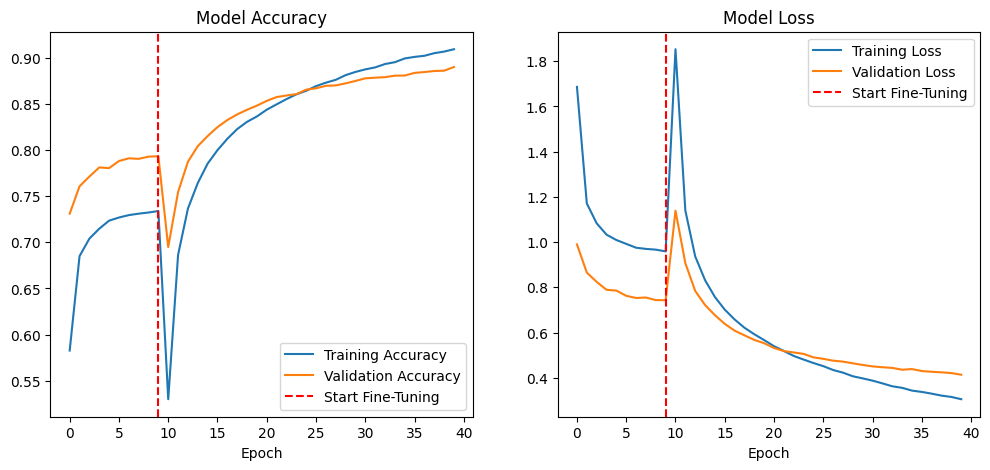

In [20]:
print("\n--- Step 10: Evaluating & Visualizing Results ---")

# 1. Load the *best* model saved by ModelCheckpoint
# This ensures we evaluate the best version, not just the last one.
print("Loading best saved model for final evaluation...")
# We must pass our augmentation layer as a custom object
best_model = tf.keras.models.load_model(
    checkpoint_path
)

# 2. Evaluate on the validation set
loss, acc = best_model.evaluate(val_ds)
print(f"\nFinal Model Accuracy on Validation Set: {acc*100:.2f}%")

# 3. Combine history objects for a complete plot
def plot_history(history_warmup, history_fine_tune):
    acc = history_warmup.history['accuracy'] + history_fine_tune.history['accuracy']
    val_acc = history_warmup.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
    loss = history_warmup.history['loss'] + history_fine_tune.history['loss']
    val_loss = history_warmup.history['val_loss'] + history_fine_tune.history['val_loss']
    
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(len(history_warmup.history['accuracy']) - 1, color='red', linestyle='--', label='Start Fine-Tuning')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(len(history_warmup.history['loss']) - 1, color='red', linestyle='--', label='Start Fine-Tuning')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    plt.show()

plot_history(history_warmup, history_fine_tune)